# Example HF calculation
This notebook demonstrates a Hartree-Fock (HF) calculation on the HeH+ ion. The purpose is to demonstrate how the equations presented in the Quantum Chemistry course can be used in practice, it is not meant to be an efficient implementation of a modern HF program.

The Python programming language has been used, it should be relatively readable, even if you have zero programming experience. In the code sections, anything after the hash symbol is a comment to help explain what is happening. A double star raises something to the power, so P&ast;&ast;2 is P squared.

The example has been adapted from the FORTRAN program in the book *Modern Quantum Chemistry* by Szabo and Ostlund. Robert Shaw (PhD student in my group) wrote some of this conversion from FORTRAN to Python.

### The molecule
Lets start by defining our molecule (HeH+). We need to define a bond distance (R, in atomic units) and the atomic numbers of the two molecules (ZA and ZB)

In [1]:
R=1.4632
ZA=2.0
ZB=1.0

### The basis set
We also need to define the basis set, in this case we will use the STO-3G minimal basis set, which consists of both exponents and contraction coefficients. We also need the Slater orbital exponents (Zeta). To make the calculations easier, we will place these in what is known as a numpy array (in this case, they are 3x3 matrices) and we will also load a maths library.

In [2]:
import math #allows us to use maths functions and constants - such as pi
from numpy import * #for the arrays
Zeta1 = 2.0925
Zeta2 = 1.24
#STO-nG values are stored in the nth column, so we could run an STO-1G or STO-2G calc if we wanted
N = 3
expon = array([[0.270950, 0.151623, 0.109818],[0.0, 0.851819, 0.405771],[0.0, 0.0, 2.22766]])
coeff = array([[1.0, 0.678914, 0.444635],[0.0, 0.430129, 0.535328],[0.0, 0.0, 0.154329]])

We're going to create some variables to hold our data: scale the exponents (A1, A2) and include normalisation in the contraction coefficients (D1, D2) of the primitive Gaussian basis functions on each nuclear centre.

In [3]:
A1 = [0.0]*3 #Place to hold A1, with everything initally set to zero
D1 = [0.0]*3
A2 = [0.0]*3
D2 = [0.0]*3
for i in range(N):
    A1[i] = expon[i][N-1]*(Zeta1**2)
    D1[i] = coeff[i][N-1]*((2*A1[i]/math.pi)**0.75)
    A2[i] = expon[i][N-1]*(Zeta2**2)
    D2[i] = coeff[i][N-1]*((2*A2[i]/math.pi)**0.75)

## Calculating integrals
Now that we have our basis set in the correct format, we can start to calculate the numerous integrals involved in a HF calculation. Lets start by intialising some variables that will hold our integrals - check the comments to find out what each variable is.

In [4]:
S12 = 0.0 #Overlap integral
T11, T12, T22 = 0.0, 0.0, 0.0 #Kinetic energy integrals
V11A, V12A, V22A = 0.0, 0.0, 0.0 #Nuclear potential energy integrals at centre A
V11B, V12B, V22B = 0.0, 0.0, 0.0 #Nuclear potential energy integrals at centre B
V1111, V2111, V2121, V2211, V2221, V2222 = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0 #Electronic potential energy, 2-e integrals

### Overlap integrals
Perhaps the simplest integral we need is the overlap integral, which can be expressed as:
\begin{equation*}
S_{pq} = \int\chi_p(1)\chi_q(1) \mathop{}\!\mathrm{d}\tau_1
\end{equation*}
We need to do this several times (a *loop* in programming terms) so we will define a procedure called S that we can run many times (when you see a line beginning with def, in means we're defining a procedure - the text inside the """ part tells us what it does).

In [5]:
def S(A, B, RAB2):
    """Calculates the overlap for primitives with exponents A and B, given the square of their separation - RAB2"""
    p1 = math.pi/(A+B)
    p2 = math.exp(-A*B*RAB2/(A+B))
    return ((p1**1.5)*p2)

Lets now calculate S. We'll need to loop over the basis functions

In [6]:
for i in range(N):
    for j in range(N):
        S12 = S12 + S(A1[i], A2[j], R**2)*D1[i]*D2[j]

We can check the value of our overlap integral by *printing* it

In [7]:
print("The value of the overlap integral is", S12)

The value of the overlap integral is 0.450770411648


You might be wondering why we only have a single value here? Good question. We already know what the value of the self overlap element must be (try to link this to concepts introduced in the course), and that the overlap matrix will be symmetric. Let's assemble and print the full overlap matrix, we'll also define a procedure for printing matrices (*matout*) that will be useful later.

In [8]:
smatrix = array([[1.0, S12], [S12, 1.0]]) #2x2 overlap matrix

def matout(amatrix, m, n, label):
    """prints out matrices of size m x n  with label"""
    print("\nThe %s matrix" % (label))
    for i in range(n):
        print("\t %i \t" % (i+1), end='') #prints matrix column indices
    print() #newline
    for j in range(m):
        print(j+1, end='') #prints matrix row indices
        for k in range(n):
            print("\t %.5f" % (amatrix[j][k]), end='')
        print() #newline
    print() #newline
    
matout(smatrix, 2, 2, "S")


The S matrix
	 1 		 2 	
1	 1.00000	 0.45077
2	 0.45077	 1.00000



### Kinetic energy and nuclear attraction integrals
At this point can also calculate our kinetic energy:
\begin{equation*}
T_i = \langle\psi_i|-\frac{1}{2}\nabla^2|\psi_i\rangle
\end{equation*}
and nuclear attraction integrals:
\begin{equation*}
V_{iA} = \langle\psi_i|-\frac{Z_A}{r_A}|\psi_i\rangle
\end{equation*}
In a similar fashion as the overlap integrals, we'll define procedures before evaluating them as part of a loop. The difference this time is that we'll use the same loop to calculate both. If you look closely you'll see that to define V, we need to define a procedure to calculate f0. We don't go into the technical details of evaluating integrals in the course, so chances are this will seem a bit alien. If you're interested in the details it's best to dive into Szabo and Ostlund.

In [9]:
def T(A, B, RAB2):
    """Calculates the kinetic energy integrals for primitives with exponents A and B, given square of their
    separation"""
    p1 = A*B/(A+B)
    p2 = 3.0 - 2*A*B*RAB2/(A+B)
    p3 = math.pi/(A+B)
    p4 = math.exp(-A*B*RAB2/(A+B))
    retval = p1*p2*(p3**1.5)*p4
    return retval

def V(A, B, RAB2, RCP2, ZC):
    """calculates the un-normalised nuclear attraction integrals with exponents A, B at the two centres, 
    square separation RAB2, square separation between points C and P, RCP2, and atomic number ZC at C."""
    p1 = 2*math.pi/(A+B)
    p2 = f0((A+B)*RCP2)
    p3 = math.exp(-A*B*RAB2/(A+B))
    retval = -1*p1*p2*p3*ZC
    return retval

def f0(arg):
    """calculates the f function for a given argument arg, for S-type orbitals"""
    if arg < 1e-6:
        retval =  1.0 - arg/3 #if arg below a given threshold, return the asymptotic value for small arguments
    else:
        retval = math.sqrt(math.pi/arg)*math.erf(math.sqrt(arg))/2
    return retval

for i in range(N):
    for j in range(N):
        #We also need a few distances that can be calculated as part of the loop
        RAP = A2[j]*R/(A1[i] + A2[j]) #Distance between centre A and centre P
        RBP2 = (R-RAP)**2 #Square of distance between centre B and centre P
        T11 = T11 + T(A1[i], A1[j], 0.0)*D1[i]*D1[j]
        T12 = T12 + T(A1[i], A2[j], R**2)*D1[i]*D2[j]
        T22 = T22 + T(A2[i], A2[j], 0.0)*D2[i]*D2[j]
        V11A = V11A + V(A1[i], A1[j], 0.0, 0.0, ZA)*D1[i]*D1[j]
        V12A = V12A + V(A1[i], A2[j], R**2, RAP**2, ZA)*D1[i]*D2[j]
        V22A = V22A + V(A2[i], A2[j], 0.0, R**2, ZA)*D2[i]*D2[j]
        V11B = V11B + V(A1[i], A1[j], 0.0, R**2, ZB)*D1[i]*D1[j]
        V12B = V12B + V(A1[i], A2[j], R**2, RBP2, ZB)*D1[i]*D2[j]
        V22B = V22B + V(A2[i], A2[j], 0.0, 0.0, ZB)*D2[i]*D2[j]

We can print out the integrals we just calculated, in a basic table form

In [10]:
print("T11 \t\t T12 \t\t T22\n")
print("%f \t %f \t %f\n" % (T11, T12, T22))
print("V11A \t\t V12A \t\t V22A\n")
print("%f \t %f \t %f\n" % (V11A, V12A, V22A))
print("V11B \t\t V12B \t\t V22B\n")
print("%f \t %f \t %f\n" % (V11B, V12B, V22B))

T11 		 T12 		 T22

2.164313 	 0.167013 	 0.760033

V11A 		 V12A 		 V22A

-4.139827 	 -1.102913 	 -1.265246

V11B 		 V12B 		 V22B

-0.677230 	 -0.411305 	 -1.226615



Just as with the overlap integrals, this is a little difficult to read and place into context with the course. Our next step is to form the *core Hamiltonian* and print it as a matrix.
\begin{equation*}
h_{pq} = \langle\chi_p|-\frac{1}{2}\nabla^2 -\frac{Z_A}{r_A}|\chi_q\rangle
\end{equation*}

In [11]:
h11 = T11 + V11A + V11B
h12 = T12 + V12A + V12B
h21 = h12
h22 = T22 + V22A + V22B
hmatrix = array([[h11, h12], [h21, h22]]) #2x2 core Hamiltonian matrix
matout(hmatrix, 2, 2, "H") #Use the procedure defined above to print the core Hamiltonian matrix


The H matrix
	 1 		 2 	
1	 -2.65274	 -1.34721
2	 -1.34721	 -1.73183



## Two-electron integrals
Now that we've dealt with the one-electron integrals and the core Hamiltonian, it's time to evaluate the two-electron integrals. Although it's slightly more involved, the principles are much the same as for the one-electron integrals - we will define a procedure, then loop over the *centres*.

The part of the HF equations we are working towards here is:
\begin{equation*}
V_{\mathrm{HF}} = \frac{1}{2}\sum^n_{i=1}\sum^n_{j=1}(J_{ij}-K_{ij})
\end{equation*}
which we can later add to the core Hamiltonian.

In [12]:
#Start by initalising the integrals (electronic potential energy) to zero
V1111, V2111, V2121, V2211, V2221, V2222 = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

def twoE(A, B, C, D, RAB2, RCD2, RPQ2):
    """calculates the two electron integrals for un-normalised primitives, with exponents A=alpha, B=beta, 
    C=gamma, D=delta ; RAB2 square separation between centres A, B; RCD2 square separation between C and D;
    RPQ2 square separation between P, Q"""
    p1 = 2.0*(math.pi**2.5)/((A+B)*(C+D)*math.sqrt(A+B+C+D))
    p2=f0((A+B)*(C+D)*RPQ2/(A+B+C+D))
    p3 = math.exp((-A*B*RAB2/(A+B))-(C*D*RCD2/(C+D)))
    return (p1*p2*p3)

for i in range(N):
    for j in range(N):
        for k in range(N):
            for l in range(N):
                #Define some distances
                RAP = A2[i]*R/(A2[i]+A1[j])
                RBP = R - RAP
                RAQ = A2[k]*R/(A2[k]+A1[l])
                RBQ = R-RAQ
                RPQ = RAP - RAQ
                #Calculate integrals
                V1111 = V1111 + twoE(A1[i], A1[j], A1[k], A1[l], 0.0, 0.0, 0.0)*D1[i]*D1[j]*D1[k]*D1[l]
                V2111 = V2111 + twoE(A2[i], A1[j], A1[k], A1[l], R**2, 0.0, RAP**2)*D2[i]*D1[j]*D1[k]*D1[l]
                V2121 = V2121 + twoE(A2[i], A1[j], A2[k], A1[l], R**2, R**2, RPQ**2)*D2[i]*D1[j]*D2[k]*D1[l]
                V2211 = V2211 + twoE(A2[i], A2[j], A1[k], A1[l], 0.0, 0.0, R**2)*D2[i]*D2[j]*D1[k]*D1[l]
                V2221 = V2221 + twoE(A2[i], A2[j], A2[k], A1[l], 0.0, R**2, RBQ**2)*D2[i]*D2[j]*D2[k]*D1[l]
                V2222 = V2222 + twoE(A2[i], A2[j], A2[k], A2[l], 0.0, 0.0, 0.0)*D2[i]*D2[j]*D2[k]*D2[l]

Print out what we just calculated, in table form.

In [13]:
print("V1111 \t\t V2111 \t\t V2121\n")
print("%f \t %f \t %f\n" % (V1111, V2111, V2121))
print("V2211 \t\t V2221 \t\t V2222\n")
print("%f \t %f \t %f\n" % (V2211, V2221, V2222))

V1111 		 V2111 		 V2121

1.307152 	 0.437279 	 0.177267

V2211 		 V2221 		 V2222

0.605703 	 0.311795 	 0.774608



Again, we will assemble this into a matrix (for later use) and we can print out the matrix

In [14]:
#form the 2x2x2x2 'matrix' of 2e integrals, but first take the 2x2 bits 'inside'
t11 = [[V1111, V2111], [V2111, V2211]] #twomatrix(x, y, 1, 1)
t12 = [[V2111, V2121], [V2121, V2221]] #twomatrix(x, y, 1, 2)
t21 = t12 #twomatrix(x, y, 2, 1)
t22 = [[V2211, V2221], [V2221, V2222]] #twomatrix(x, y, 2, 2)
twomatrix = array([[t11, t12], [t21, t22]])

#print 2e matrix
for i in range(2):
    for j in range(2):
        for k in range(2):
            for l in range(2):
                print("( %i %i %i %i ) \t %f" % (i+1, j+1, k+1, l+1, twomatrix[i][j][k][l]))

( 1 1 1 1 ) 	 1.307152
( 1 1 1 2 ) 	 0.437279
( 1 1 2 1 ) 	 0.437279
( 1 1 2 2 ) 	 0.605703
( 1 2 1 1 ) 	 0.437279
( 1 2 1 2 ) 	 0.177267
( 1 2 2 1 ) 	 0.177267
( 1 2 2 2 ) 	 0.311795
( 2 1 1 1 ) 	 0.437279
( 2 1 1 2 ) 	 0.177267
( 2 1 2 1 ) 	 0.177267
( 2 1 2 2 ) 	 0.311795
( 2 2 1 1 ) 	 0.605703
( 2 2 1 2 ) 	 0.311795
( 2 2 2 1 ) 	 0.311795
( 2 2 2 2 ) 	 0.774608


## SCF iterations
Now that we have the one- and two-electron integrals, we can solve our HF equations in a self-consistent manner (see the flowchart from the lecture notes).

Let's start by defining our convergence criteria and our maximum number of iterations

In [15]:
CONVERGE = 1e-4 #Convergence criterion for density matrix
MAXIT = 25 #Maximum number of SCF iterations

We also need to initalise some matrices (including the density matrix) and while we are at, let's start a counter for the number of iterations and a variable containing the current energy. As we will use changes in the density matrix as our check for the SCF iterations converging, it's worth remembering its form:
\begin{equation*}
\rho_{qp} = \sum_{i}c_{qi}c_{pi}^*
\end{equation*}
where $c_{qi}$ are variational parameters.

In [16]:
pmatrix = array([[0.0, 0.0], [0.0, 0.0]]) #initialise density matrix
oldpmatrix = array([[0.0,0.0], [0.0,0.0]]) #to store old density matrix before forming new one
ematrix = [] #matrix of eigenvalues
gmatrix = [] #two-electron part of the Fock matrix
fmatrix = [] #Fock matrix
cmatrix = [] #matrix of variational parameters

curriter = 0 #Current iteration index
energy = 0.0 #initialise energy variable
energs = [] #list of energies throughout the calculation
deltas = [] #keep track of how the change in the density matrix progresses

### The Fock matrix
The elements of the Fock matrix are given by:
\begin{equation*}
F_{pq} = h_{pq} + \sum_{rs}\langle\chi_p\chi_r ||\chi_q\chi_s \rangle
\end{equation*}
where the first term is the core Hamiltonian (which we have already calculated and doesn't change during the SCF).
This means we need to calculate the second term (two-electron part), we will call this the gmatrix and define a procedure to calculate it.

In [17]:
def formg(pmatrix, twomatrix):
    """calculates the G matrix from the density matrix and 2e integrals"""
    gmatrix = array([[0.0, 0.0], [0.0, 0.0]]) #initialise return matrix
    for i in range(2):
        for j in range(2):
            for k in range(2):
                for l in range(2):
                    gmatrix[i][j] = gmatrix[i][j] + pmatrix[k][l]*(twomatrix[i][j][k][l]-0.5*twomatrix[i][l][k][j])
    return gmatrix

We also need a transformation matrix (xmatrix) and its transpose, which is used in the secular equations

In [18]:
#use canonical orthogonalisation to find transformation matrix, X
x11 = 1/math.sqrt(2*(1+S12))
x12 = 1/math.sqrt(2*(1-S12))
x21 = x11
x22 = -x12
xmatrix = array([[x11, x12], [x21, x22]]) #transformation matrix
xtmatrix = array([[x11, x21], [x12, x22]]) #transpose of transformation matrix

### Matrix multiplication and diagonalisation
To be able to carry out matrix multiplication and to diagonalise a matrix (used to find the eigenvalues of a matrix), we need to define procedures for both of those. In practice, it would be better to use existing procedures (such as those provided in the *numpy* Python module) as they are likely to be faster and extensively checked for programming bugs. Here we have written our own versions, so you can see how it's done.

In [19]:
def mult(amatrix, bmatrix, n, m):
    """multiplies two n x n matrices (a and b)"""
    cmatrix = array([[0.0]*n]*n) #initialise n x n matrix
    for i in range(m):
        for j in range(m):
            for k in range(m):
                cmatrix[i][j] = cmatrix[i][j] + amatrix[i][k]*bmatrix[k][j]
    return cmatrix

def diag(amatrix):
    """diagonalises amatrix and returns matrices of the eigenvectors and eigenvalues"""
    vecmatrix = array([[0.0, 0.0], [0.0, 0.0]]) #Eigenvectors
    valmatrix = array([[0.0, 0.0], [0.0, 0.0]]) #Eigenvalues
    theta = 0.0 #Angle describing the solution
    #Check whether homo or heteronuclear diatomic
    if (math.fabs(amatrix[0][0] - amatrix[1][1])) < (1e-20):
        #Homonuclear diatomic
        theta = math.pi/4
    else:
        #Heteronuclear diatomic
        theta = 0.5*math.atan(2*amatrix[0][1]/(amatrix[0][0] - amatrix[1][1]))
    #Enumerate the eigenvectors from theta
    vecmatrix[0][0] = math.cos(theta)
    vecmatrix[0][1] = math.sin(theta)
    vecmatrix[1][0] = vecmatrix[0][1]
    vecmatrix[1][1] = -1*vecmatrix[0][0]
    #Split up calculation of eigenvalues into parts
    p1 = amatrix[0][0]*(vecmatrix[0][0])**2
    p2 = amatrix[1][1]*(vecmatrix[0][1])**2
    p3 = amatrix[0][1]*math.sin(2*theta)
    p4 = amatrix[1][1]*(vecmatrix[0][0])**2
    p5 = amatrix[0][0]*(vecmatrix[0][1])**2
    #Enumerate eigenvalues
    valmatrix[0][0] = p1 + p2 + p3
    valmatrix[1][1] = p4 + p5 - p3
    valmatrix[0][1] = 0 #Redundant, but for clarity
    valmatrix[1][0] = 0
    #Order the eigenvalues and vectors if necessary
    if valmatrix[1][1] < valmatrix[0][0]:
        #Order eigenvalues smallest first
        temp = valmatrix[1][1] #Save the smaller value
        valmatrix[1][1] = valmatrix[0][0] #Put higher value in second position
        valmatrix[0][0] = temp #and lower value in first position
        #Now swap the vectors
        temp = vecmatrix[0][1]
        vecmatrix[0][1] = vecmatrix[0][0]
        vecmatrix[0][0] = temp
        temp = vecmatrix[1][1]
        vecmatrix[1][1] = vecmatrix[1][0]
        vecmatrix[1][0] = temp
    return [vecmatrix, valmatrix] #return list of eigenvectors and values

### The actual calculation
We now have all the pieces required to run an SCF calculation. A basic overview of the process is:
1. Generate the Fock matrix from the core Hamiltonian and two-electron matrix
2. Calculate the current energy: $\tilde{E}(\mathbf{c}) = \sum_{i=1}^n h_i + \frac{1}{2}\sum_{i=1}^n\sum_{j=1}^n (J_{ij}-K_{ij})$
3. Solve the secular / Roothaan equations ($|\mathbf{F}-\epsilon\mathbf{S}|=0$ and $\mathbf{Fc}=\mathbf{Sc\epsilon}$) to obtain orbital energies and a new variational parameters
4. Form a new density matrix from the variational parameters
5. Calculate the *magnitude* of the denisty matrix and compare with the previous value. If the change in magnitude (called *delta* in the code below) is less than the convergence threshold then the SCF calculation is complete. Otherwise, go back to point 1.

In [20]:
while True:
    curriter = curriter + 1
    print("START OF ITERATION NUMBER = %i" % (curriter))
    gmatrix = formg(pmatrix, twomatrix) #form 2e part of Fock matrix from current density matrix
    matout(gmatrix, 2, 2, "G") #Use earlier procedure to print the G matrix
    fmatrix = hmatrix + gmatrix #generate Fock matrix from sum of core Hamiltonian and 2e matrix
    #Calculate electronic energy
    energy = 0.0 #reset energy
    for p in range(2):
        for q in range(2):
            energy = energy + 0.5*pmatrix[p][q]*(hmatrix[p][q] + fmatrix[p][q])
    matout(fmatrix, 2, 2, "F") #Print current Fock matrix
    print("Electronic energy = %f Hartree" % (energy))
    energs.append(energy) #Add the current energy to our list
    #Transform Fock matrix, reusing gmatrix for temporary storage
    gmatrix = mult(fmatrix, xmatrix, 2, 2)
    fpmatrix = mult(xtmatrix, gmatrix, 2, 2) #Fock-prime matrix - transformed Fock matrix
    #Diagonalise the transformed Fock matrix
    eigenmatrix = diag(fpmatrix) #Get eigenvectors and eigenvalues
    cpmatrix = eigenmatrix[0] #Eigenvectors
    ematrix = eigenmatrix[1] #Eigenvalues
    cmatrix = mult(xmatrix, cpmatrix, 2, 2) #Transform eigenvectors to get matrix C
    #Form new density matrix and save current density matrix
    for p in range(2):
        for q in range(2):
            oldpmatrix[p][q] = pmatrix[p][q]
            pmatrix[p][q] = 2*cmatrix[p][0]*cmatrix[q][0]
    matout(fpmatrix, 2, 2, "F prime") #Print transformed Fock matrix
    matout(ematrix, 2, 2, "Eigenvalues")
    matout(cmatrix, 2, 2, "Eigenvectors")
    matout(pmatrix, 2, 2, "P")
    #Calculate delta, the change in 'magnitude' of the density matrix
    delta = 0.0
    for p in range(2):
        for q in range(2):
            delta = delta + (pmatrix[p][q] - oldpmatrix[p][q])**2
    delta = math.sqrt(delta/4)
    deltas.append(delta) #Add the latest delta to the list
    print("Delta(Convergence of Density Matrix) = %f" % (delta))
    #Check for convergence against criterion
    if delta < CONVERGE:
        print("\nSCF Converged after %i iterations" % (curriter))
        break
    elif curriter is MAXIT:
        print("\nNo convergence after maximum number of iterations")
        break


START OF ITERATION NUMBER = 1

The G matrix
	 1 		 2 	
1	 0.00000	 0.00000
2	 0.00000	 0.00000


The F matrix
	 1 		 2 	
1	 -2.65274	 -1.34721
2	 -1.34721	 -1.73183

Electronic energy = 0.000000 Hartree

The F prime matrix
	 1 		 2 	
1	 -2.43973	 -0.51584
2	 -0.51584	 -1.53867


The Eigenvalues matrix
	 1 		 2 	
1	 -2.67409	 0.00000
2	 0.00000	 -1.30431


The Eigenvectors matrix
	 1 		 2 	
1	 0.92915	 -0.62586
2	 0.13983	 1.11151


The P matrix
	 1 		 2 	
1	 1.72663	 0.25985
2	 0.25985	 0.03911

Delta(Convergence of Density Matrix) = 0.882867
START OF ITERATION NUMBER = 2

The G matrix
	 1 		 2 	
1	 1.26233	 0.37400
2	 0.37400	 0.98895


The F matrix
	 1 		 2 	
1	 -1.39041	 -0.97320
2	 -0.97320	 -0.74288

Electronic energy = -4.141863 Hartree

The F prime matrix
	 1 		 2 	
1	 -1.40604	 -0.36271
2	 -0.36271	 -0.17014


The Eigenvalues matrix
	 1 		 2 	
1	 -1.50463	 0.00000
2	 0.00000	 -0.07155


The Eigenvectors matrix
	 1 		 2 	
1	 0.81676	 -0.76675
2	 0.31626	 1.07470


The P matrix
	

Lets look at the final energy (all in Hartree). To calculate the total energy, we add the electronic contribution from our SCF calculation to the (constant) nuclear-nuclear repulsion term.

In [21]:
etotal = energy + ZA*ZB/R
print("Electronic Energy = %f \nTotal Energy = %f \n" % (energy, etotal))

Electronic Energy = -4.227529 
Total Energy = -2.860662 



## Plotting the changes in energy
As we stored the energy (and delta values) at each step in our calculation, we can also plot this data to see how it changed over the iterations. We will use the Python matplotlib library to quickly and easily do this.

Our starting "guess" for the density matrix was to set all elements to zero, meaning the first electronic energy is zero - hence we will skip it in the plot. Most HF programs used in research have a more sophisticated guess, which will give a more logical first energy (and usually lead to convergence in fewer iterations).

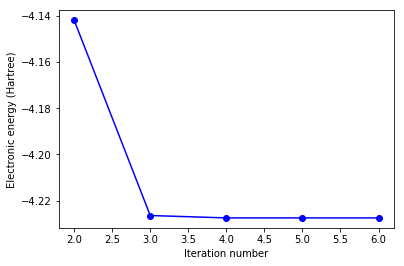

In [24]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots()
axes.plot(range(2,curriter+1),energs[1:], 'bo-')
axes.set_xlabel("Iteration number")
axes.set_ylabel("Electronic energy (Hartree)")
plt.show()

We can see that there's a large jump in energy between the second and third iteration, but after that the change in energy is relatively small. We can look at this in a bit more detail though, try changing the line
> `plt.plot(range(2,curriter+1),energs[1:], 'bo-')`

to

> `plt.plot(range(3,curriter+1),energs[2:], 'bo-')`

Then press the run arrow button in the toolbar at the top. This will plot iteration 3 onwards.

While the total energy is probably the output of the calculation we are most interested in, it isn't directly used to test if the calculation has converged.

### Plotting delta
The variable delta holds the change in the magnitude of the density matrix between iterations. As this is the quantity we are using to check for convergence, let's go ahead and plot that too.

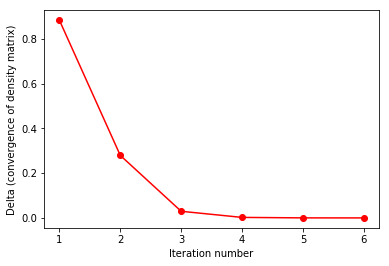

In [23]:
fig, axes = plt.subplots()
axes.plot(range(1,curriter+1),deltas, 'ro-')
axes.set_xlabel("Iteration number")
axes.set_ylabel("Delta (convergence of density matrix)")
plt.show()

As we might have expected, there's a large change in the first iteration (due to the terrible initial density guess), but it converges pretty rapidly after that. If we were observing large oscillations in delta or the energy this would be a sign that we were experiencing convergence problems, but everything looks good here.

## Time to experiment
As this is an interactive notebook, you can play around with some of the parameters, convergence criteria etc. to erxamine the impact on the energy. Make a change, then press the double arrow *re-run* button in the toolbar (looks like an old school fast forward button). This will restart the notebook with your new parameters.

You could examine how the energy changes when you try some of the following (probably best to try these one at a time to start with):
1. Adjust the bond length R
2. Try different hydrogenic ions by adjusting the atomic numbers ZA and ZB. Note these will always be one electron ions, so carbon (ZA=6) would actually be the C$^{5+}$ ion.
3. Use the STO-2G or STO-1G basis set by changing the value of N in the basis set section.
4. Change the convergence criteria CONVERGE. At what point does the calculation no longer converge?